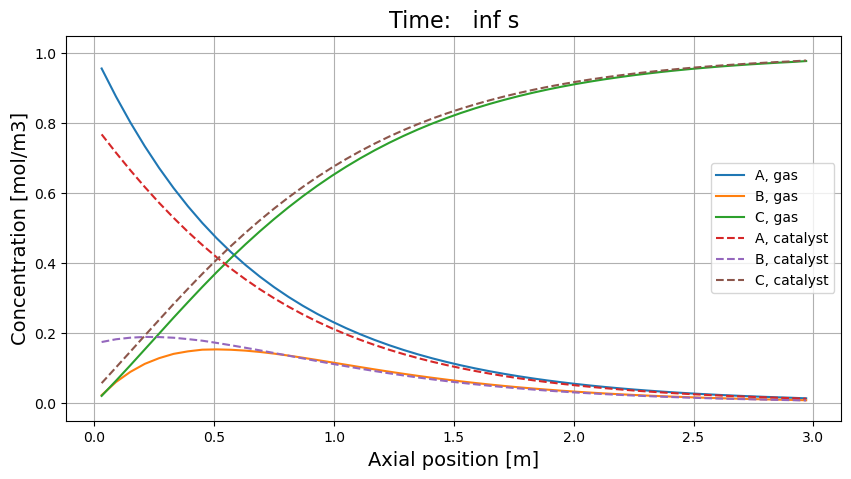

In [2]:
# Exercise 7.2b: Axially dispersed plug flow reactor: heterogeneous model for multi-component system

import numpy as np
import matplotlib.pyplot as plt
import pymrm as mrm

#import Maxwell_Stefan_tools as ms

class axially_dispersed_plug_flow_reactor:
    def __init__(self):
        self.Dax = [[[1.0e-5], [0.0]]]
        self.v = [[[1.0], [0.0]]]
        self.L = 3.0
        self.k1 = 5.0
        self.k_1 = 2.0
        self.k2 = 10.0
        self.eps_s = 0.4
        self.eps_f = 1.0-self.eps_s
        dp = 1e-3
        a = (6.0/dp*self.eps_s) # specific surface area
        self.kma01 = 0.005*a
        self.kma12 = 0.02*a
        self.kma02 = 0.02*a
                
        self.nz = 50
        self.np = 2 # number of phases
        self.nc = 3 # number of components
        self.dt = np.inf

        self.c0 = [[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]]
        self.cin = [[[1.0, 0.0, 0.0], [0.0, 0.0, 0.0]]]
        
        self.vel_cin = np.array(self.v)*np.array(self.cin)

        self.bc_ax = {'a':[self.Dax, 1.0], 'b':[self.v, 0.0], 'd':[self.vel_cin, 0.0]}
        
        self.z_f = np.linspace(0, self.L, self.nz+1)
        self.z_c = 0.5*(self.z_f[0:-1] + self.z_f[1:])

        self.init_field(self.c0)
        self.init_Jac()
        self.freq_out = 1
    
    def init_field(self, c0):
        self.c = np.full((self.nz, self.np, self.nc), c0, dtype='float')
    
    def kinetics(self, c):
        r = np.zeros_like(c)
        r1 = self.k1*c[:,0]
        r_1 = self.k_1*c[:,1]
        r2 = self.k2*c[:,1]
        r[:,0] = -r1 + r_1
        r[:,1] = r1 - r_1 - r2
        r[:,2] = r2
        return r
        
    def reaction_and_mt(self, c):
        r = self.kinetics(c[:,1,:])
        f = np.zeros_like(c)
        f[:,0,:] = self.eps_s*r
        driving_force = c[:,1,:]-c[:,0,:]
        f[:,1,:] = r/self.kma01 - driving_force
        return f
    
    def reaction_and_mt_ms(self, c):
        r = self.kinetics(c[:,1,:])
        f = np.zeros_like(c)
        f[:,0,:] = self.eps_s*r
        driving_force = c[:,1,:]-c[:,0,:]
        c_mid = np.mean(c, axis=-2)
        mol_frac = c_mid / np.sum(c_mid,axis=-1,keepdims = True)
        f[:,1,0] = (mol_frac[:,1]*r[:,0]-mol_frac[:,0]*r[:,1])/self.kma01 + (mol_frac[:,2]*r[:,0]-mol_frac[:,0]*r[:,2])/self.kma02 - driving_force[:,0]
        f[:,1,1] = (mol_frac[:,2]*r[:,1]-mol_frac[:,1]*r[:,2])/self.kma12 + (mol_frac[:,0]*r[:,1]-mol_frac[:,1]*r[:,0])/self.kma01 - driving_force[:,1]
        f[:,1,2] = (mol_frac[:,0]*r[:,2]-mol_frac[:,2]*r[:,0])/self.kma02 + (mol_frac[:,1]*r[:,2]-mol_frac[:,2]*r[:,1])/self.kma12 - driving_force[:,2]
        return f
    
    def init_Jac(self):
        self.Jac_accum = mrm.construct_coefficient_matrix([[[self.eps_f/self.dt],[0.0]]], self.c.shape)
        Grad, grad_bc = mrm.construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = mrm.construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = mrm.construct_div(self.c.shape, self.z_f, nu=0, axis=0)
        D_matrix = mrm.construct_coefficient_matrix(self.Dax, self.c.shape, axis=0)  
        self.Flux_ax = Conv - D_matrix @ Grad
        self.flux_ax_bc = conv_bc - D_matrix @ grad_bc
        self.g_const = self.Div_ax @ self.flux_ax_bc
        self.Jac_const = self.Jac_accum + self.Div_ax @ self.Flux_ax
            
    def lin_pde(self, c, c_old):
        f_react, Jac_react = mrm.numjac_local(self.reaction_and_mt_ms, c, axis=[-2,-1])
        c_f , dc_f = mrm.interp_cntr_to_stagg_tvd(c, self.z_f, self.z_c, self.bc_ax, self.v, mrm.minmod)
        dg_conv = self.Div_ax @ (self.v*dc_f).reshape((-1,1))
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) + dg_conv - self.Jac_accum @ c_old.reshape((-1,1)) - f_react.reshape((-1,1))
        Jac = self.Jac_const - Jac_react
        return g, Jac
                 
    def solve(self, nt):
        self.plot_pre()
        for i in range(1,nt+1):
            print(f'{i}\r',end='')
            c_old = self.c.copy()
            result = mrm.newton(lambda c: self.lin_pde(c, c_old), c_old)
            self.c = result.x.copy()
            if (i % self.freq_out == 0):
                self.plot(i*self.dt)
    
    def plot_pre(self):
        plt.ion()
        self.fig, self.ax = plt.subplots(figsize=(10,5))
        self.line = [[] for _ in range(self.np)]
        for i in range(self.nc):
            self.line[0].append(self.ax.plot(self.z_c, self.c[:,0,i], '-', label=chr(ord('A')+i)+', gas')[0])
        for i in range(self.nc):
            self.line[1].append(self.ax.plot(self.z_c, self.c[:,1,i], '--', label=chr(ord('A')+i)+', catalyst')[0])
        self.ax.set_title(f"Time: {0.0:5.3f} s", fontsize=16)
        self.ax.set_xlabel("Axial position [m]", fontsize=14)
        self.ax.set_ylabel("Concentration [mol/m3]", fontsize=14)
        # self.ax.set_xlim(0, self.L)
        # self.ax.set_ylim(0, 1.2*np.max(self.cin))
        self.ax.grid()
        self.ax.legend()
                
    def plot(self, t):
        self.ax.set_title(f"Time: {t:5.3f} s", fontsize=16)
        for j in range(self.np):
            for i in range(self.nc):
                self.line[j][i].set_ydata(self.c[:,j,i])
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
reactor = axially_dispersed_plug_flow_reactor()
reactor.solve(1)